# single-cell Progeny Production analysis
This notebook provides a central place to integrate and analyze transcriptome and progeny production data.

## Notebook setup
First give paths and values to all variables. Then, load in data.

Python imports:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy

import pandas as pd

import plotnine as p9

import scanpy

import scipy

import statsmodels.stats.multitest

import subprocess

Input data paths. Currently hardcoded.

In [2]:
matrix = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/matrix.mtx'
cell_barcodes = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/barcodes.tsv'
features = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/features.tsv'
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_background_freq_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_background_freq.csv.gz'
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny_freq.csv.gz'

Global variables for this notebook:

In [3]:
expt = 'scProgenyProduction_trial3'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf'
viral_genes = ['fluPB2', 'fluPB1', 'fluPA', 'fluHA', 'fluNA', 'fluNP', 'fluM', 'fluNS']
barcoded_viral_genes = ['fluHA', 'fluNA']

Style parameters. *N.b.* `CBPALETTE` is defined in imports above.

In [4]:
p9.theme_set(p9.theme_classic())

### Load data

**Transcriptome** viral barcode frequencies:

In [5]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_background_freq_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(transcriptome_viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0,0.000000,False
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0,0.000000,False
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0,0.000000,False
3,AAACGAAGTACTTCCC,True,both,0.448272,fluHA,NaN,0,0.000000,False
4,AAACGAAGTAGACGTG,True,wt,0.040116,fluHA,AAGTAAGCGACATGAG,93,0.001731,True
...,...,...,...,...,...,...,...,...,...
9185,TTTGATCTCCCGTTCA,False,none,0.000109,fluNA,NaN,0,0.000000,False
9186,TTTGATCTCGCATTGA,True,wt,0.063156,fluNA,NaN,0,0.000000,False
9187,TTTGGAGAGTTGCCTA,False,none,0.000070,fluNA,NaN,0,0.000000,False
9188,TTTGGAGGTATCGTTG,True,wt,0.024534,fluNA,ACATCTTATTTACACG,15,0.000230,True


**Progeny** viral barcode frequencies:

*N.b. For now just work with supernatant data. Remove second_infection frequencies.*

In [6]:
progeny_viral_bc_freqs = pd.read_csv(viral_bc_in_progeny_freq_csv)
assert set(progeny_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .rename(columns={'barcode': 'viral_barcode',
                                           'tag': 'infecting_viral_tag',
                                           'mean_freq': 'freq_sup',
                                           'mean_count': 'count_sup'}))
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .query('source == "supernatant"'))
progeny_viral_bc_freqs = progeny_viral_bc_freqs.drop(columns = 'source')
display(progeny_viral_bc_freqs)

,infecting_viral_tag,gene,viral_barcode,freq_sup
0,syn,fluHA,AAAAAAGCACGAGCAG,2.507618e-07
1,syn,fluHA,AAAAGATCTTCGGTTT,5.627755e-04
2,syn,fluHA,AAAAGCACTGTAAGAT,6.539044e-04
3,syn,fluHA,AAAAGTGTATTATAAA,1.509139e-03
4,syn,fluHA,AAAATTGTAACTGATG,6.000984e-04
...,...,...,...,...
7066,wt,fluNA,TTTTCGTGAAAAGAGA,1.747121e-03
7067,wt,fluNA,TTTTGCTTCGAGATAG,1.264800e-02
7068,wt,fluNA,TTTTGGTTGTGAGGTG,2.399886e-07
7069,wt,fluNA,TTTTGTTACATCATCT,2.399886e-07


Cell-gene matrix:

In [7]:
adata = scanpy.read_mtx(matrix)
adata.var = pd.read_csv(cell_barcodes,
                        names=['cell_barcode'])
adata.obs = pd.read_csv(features,
                        sep='\t',
                        names=['ensemble_id', 'gene', 'feature_type'])

print(f"Read cell-gene matrix of {adata.n_vars} cells and {adata.n_obs} genes")

assert set(viral_genes).issubset(set(adata.obs['gene'])), 'lack viral genes'

Read cell-gene matrix of 3368 cells and 30959 genes


### Cross-check data
Use assert statements to ensure that that the number and identity of cell barcodes is identical between data sources.

In [8]:
assert transcriptome_viral_bc_freqs['cell_barcode'].nunique() == \
       adata.var['cell_barcode'].nunique(), \
       "Number of cells discrepancy"

assert set(transcriptome_viral_bc_freqs['cell_barcode']) == \
       set(adata.var['cell_barcode']), \
       "Cell barcodes do not match between data sources"

### Plot raw data
Plot data from each source without filtering or processing. This is mostly for exploration and transparency.

#### Viral barcode transcription

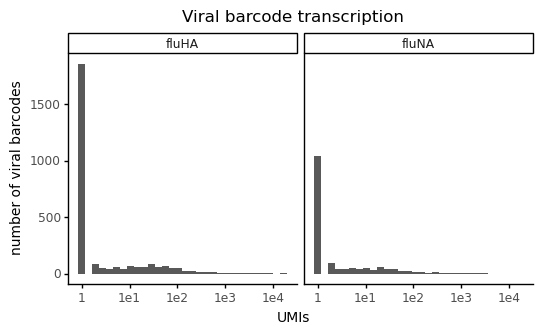

<ggplot: (8738040942415)>

In [9]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='UMIs',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

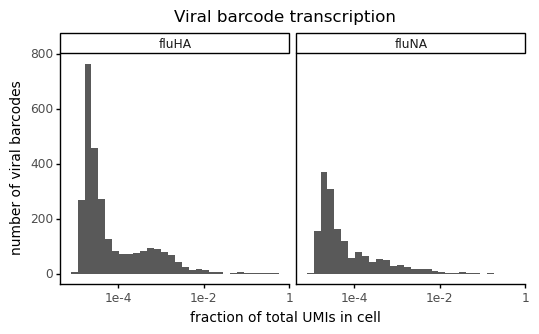

<ggplot: (8738040724565)>

In [10]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='fraction of total UMIs in cell',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

#### Progeny production: supernatant

In [11]:
fig = (p9.ggplot(progeny_viral_bc_freqs,
                 p9.aes(x='count_sup')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcodes in supernatant') +
       p9.labs(x='average reads in supernatant (two replicates)',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

PlotnineError: "Could not evaluate the 'x' mapping: 'count_sup' (original error: name 'count_sup' is not defined)"

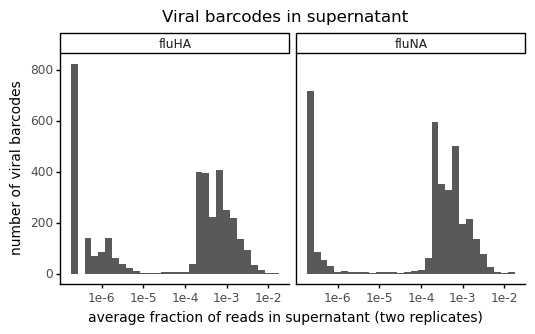

<ggplot: (8738040038018)>

In [12]:
fig = (p9.ggplot(progeny_viral_bc_freqs,
                 p9.aes(x='freq_sup')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcodes in supernatant') +
       p9.labs(x='average fraction of reads in supernatant (two replicates)',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

### Process data
Next, I will merge the data into a few useable dataframes. I will perform calculations on these data that will help us visualize technical error and filter.

#### Merge all viral barcode data into a central dataframe called `viral_bc_freqs`

Structure of the final dataframe should be as follows:
1. Cell barcode
2. Infected
3. Infecting viral tag
4. Gene
5. Viral barcode
6. Count in the transcriptome (`viral_bc_UMIs`)
7. Frequency in transcriptome (`frac_viral_bc_UMIs`)
8. Count in the supernatant sequencing (`count_sup`)
9. Frequency in supernatant sequencing (`freq_sup`)

In [13]:
viral_bc_freqs = pd.merge(
    left=transcriptome_viral_bc_freqs,
    right=progeny_viral_bc_freqs,
    how='outer',
    on=['viral_barcode', 'gene', 'infecting_viral_tag'])

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN
3,AAACGCTCAAATGATG,False,none,0.000107,fluHA,NaN,0.0,0.0,False,NaN
4,AAACGCTCATGGACAG,False,none,0.000119,fluHA,NaN,0.0,0.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...
15886,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,4.057614e-03
15887,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,1.747121e-03
15888,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,2.399886e-07
15889,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,2.399886e-07


Fill `NA` values in supernatant with `0`. It is meaningful if a viral barcode is seen in the transcriptome but absent from the supernatant; no progeny was produced by that infected cell.

In [14]:
viral_bc_freqs[['count_sup', 'freq_sup']] = (
    viral_bc_freqs[['count_sup', 'freq_sup']]
    .fillna(0)
)

viral_bc_freqs

KeyError: "['count_sup'] not in index"

Get total UMIs per cell. Get viral UMI counts and fractions per cell. Assert that these match what is already found in `viral_bc_freqs`:

In [15]:
umi_counts = (
    adata.var
    .assign(total_UMIs=numpy.sum(adata.X, axis=0).A1.astype(int),
            viral_UMIs=numpy.sum(adata[adata.obs['gene']
                                       .isin(viral_genes), ].X,
                                 axis=0).A1.astype(int),
            )
    )

viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=umi_counts,
    how='outer',
    on=['cell_barcode'])

test_viral_frac_UMIs = pd.Series(
    viral_bc_freqs['viral_UMIs'] / viral_bc_freqs['total_UMIs'],
    name='frac_viral_UMIs')

pd.testing.assert_series_equal(
    test_viral_frac_UMIs, viral_bc_freqs['frac_viral_UMIs'])

viral_bc_freqs

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup,total_UMIs,viral_UMIs
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,20969.0,1.0
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,NaN,20969.0,1.0
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,39505.0,2.0
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,NaN,39505.0,2.0
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,49137.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15886,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,4.057614e-03,NaN,NaN
15887,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,1.747121e-03,NaN,NaN
15888,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,2.399886e-07,NaN,NaN
15889,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,2.399886e-07,NaN,NaN


#### Raw correlation of viral transcription and progeny production
Plot raw data:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


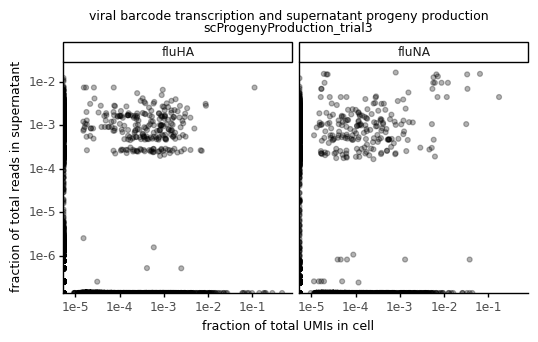

<ggplot: (8737385569416)>

In [16]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle('viral barcode transcription and supernatant progeny production\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

#### Plot annotated by infection status

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


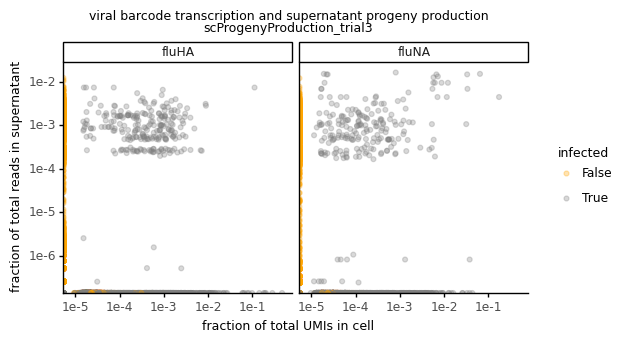

<ggplot: (8738040716933)>

In [17]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup',
                        color='infected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle('viral barcode transcription and supernatant progeny production\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

#### Plot annotated by variant

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


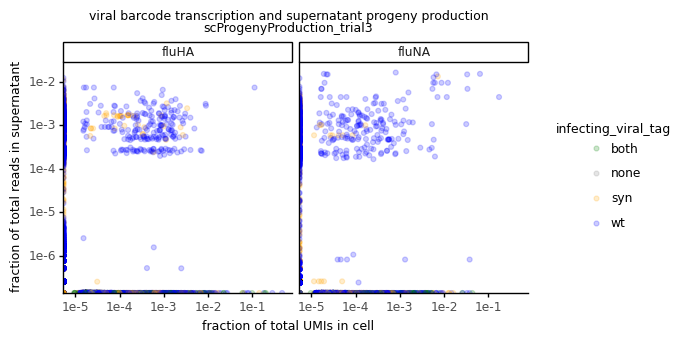

<ggplot: (8737385569386)>

In [18]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup',
                        color='infecting_viral_tag')) +
       p9.geom_point(alpha=0.2) +
       p9.facet_grid('~gene') +
       p9.ggtitle('viral barcode transcription and supernatant progeny production\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['green','grey','orange','blue']))
display(fig)

#### Significant viral barcodes found above background frequency in uninfected cells
During viral barcode processing from the transcriptome, the frequency of viral barcodes is calculated in uninfected cells. A poisson distribution is built around the expected number of UMIs for each cell-gene, and viral barcodes are called as significant if they reject the null hypothesis that they are pulled from this distribution.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


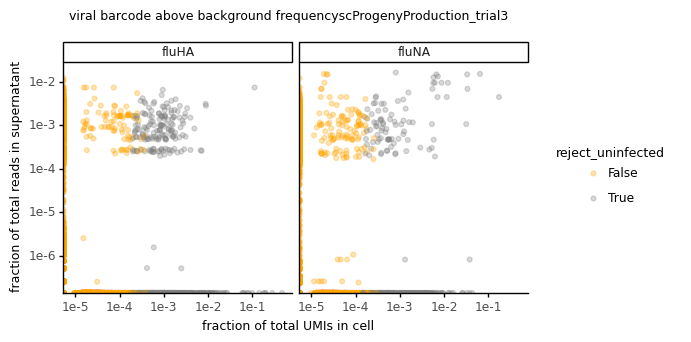

<ggplot: (8738040769762)>

In [19]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup',
                        color='reject_uninfected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle('viral barcode above background frequency'
                  f'{expt}\n') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

#### Viral barcode sharing across cells
How often is a significant viral barcode found in more than one cell? This should be very unlikely in a low MOI infection.

In [20]:
n_cell_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'viral_barcode',
                       'reject_uninfected'])
             ['cell_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'cell_barcode': 'n_cell_bc'}))

n_cell_bc

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_cell_bc,
    on=['infecting_viral_tag',
        'gene',
        'viral_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup,total_UMIs,viral_UMIs,n_cell_bc
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,49137.0,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,4.057614e-03,NaN,NaN,NaN
15887,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,1.747121e-03,NaN,NaN,NaN
15888,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN
15889,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN


Plot distribution of cell barcode per viral barcode.

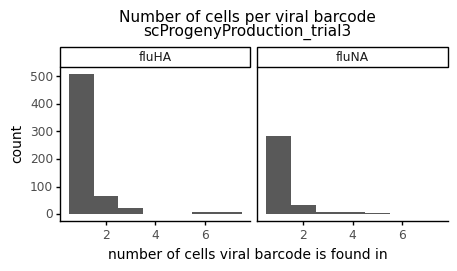

<ggplot: (8737369200541)>

In [21]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_cell_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of cells per viral barcode\n'
                  f'{expt}') +
       p9.xlab('number of cells viral barcode is found in') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label viral barcodes that are found in more than 1 cells.

In [22]:
viral_bc_freqs['gt1_cell'] = (
    viral_bc_freqs['n_cell_bc'] > 1)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN,False
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN,False
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN,False
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN,False
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,49137.0,10.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,4.057614e-03,NaN,NaN,NaN,False
15887,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,1.747121e-03,NaN,NaN,NaN,False
15888,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN,False
15889,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN,False


Plot number of viral barcodes that were found in more than 1 cell:

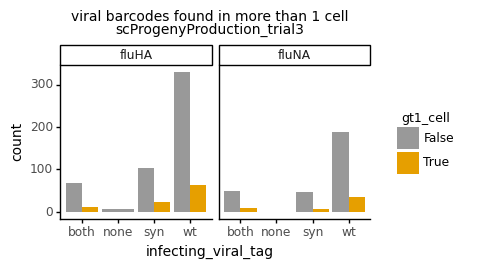

<ggplot: (8737369827690)>

In [23]:
fig = (p9.ggplot((viral_bc_freqs
                  .query('(reject_uninfected == True) and '
                         '(cell_barcode.notna())',
                         engine='python')),
                 p9.aes(x='infecting_viral_tag',
                        fill='gt1_cell')) +
       p9.geom_bar(stat='count', position='dodge') +
       p9.ggtitle('viral barcodes found in more than 1 cell\n'
                  f'{expt}') +
       p9.facet_grid('~gene') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

#### Plot annotated with significant viral barcodes found in more than one cell

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


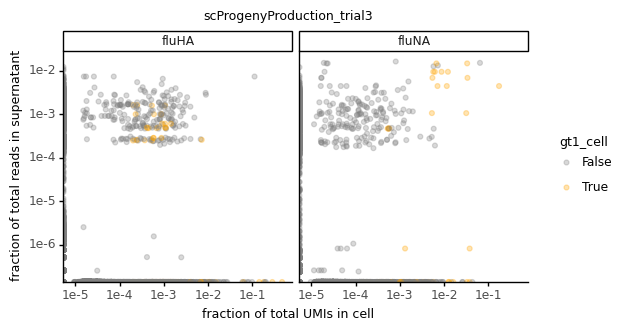

<ggplot: (8737369087148)>

In [24]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup',
                        color='gt1_cell')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

#### Viral barcodes per cell
Count the number of significant viral barcodes (above background) in each cell on each segment.

In [25]:
n_viral_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'cell_barcode',
                       'reject_uninfected'])
             ['viral_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'viral_barcode': 'n_viral_bc'}))

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_viral_bc,
    on=['infecting_viral_tag',
        'gene',
        'cell_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN,False,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN,False,NaN
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN,False,NaN
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN,False,NaN
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,49137.0,10.0,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,4.057614e-03,NaN,NaN,NaN,False,NaN
15887,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,1.747121e-03,NaN,NaN,NaN,False,NaN
15888,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN,False,NaN
15889,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN,False,NaN


Plot distribution of viral barcode per cell.

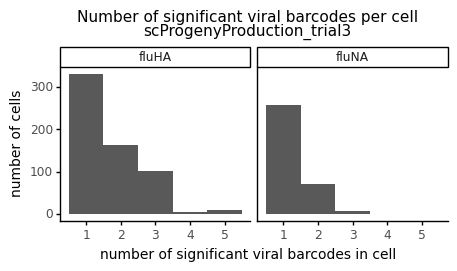

<ggplot: (8737385521116)>

In [26]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_viral_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of significant viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('number of significant viral barcodes in cell') +
       p9.ylab('number of cells') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label cells that have more than 1 viral barcode on a segment.

In [27]:
viral_bc_freqs['gt1_viral_bc'] = (
    viral_bc_freqs['n_viral_bc'] > 1)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN,False,NaN,False
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN,False,NaN,False
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN,False,NaN,False
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN,False,NaN,False
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,49137.0,10.0,NaN,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,4.057614e-03,NaN,NaN,NaN,False,NaN,False
15887,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,1.747121e-03,NaN,NaN,NaN,False,NaN,False
15888,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN,False,NaN,False
15889,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN,False,NaN,False


Plot number of cells with more than 1 significant viral barcode

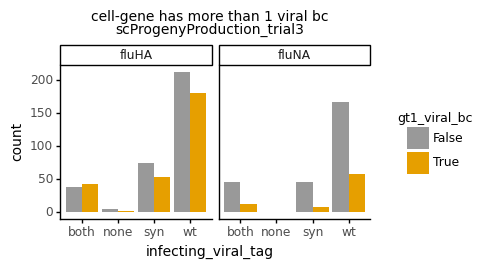

<ggplot: (8738040041204)>

In [28]:
fig = (p9.ggplot((viral_bc_freqs
                         .query('(reject_uninfected == True) and '
                                '(cell_barcode.notna())',
                                engine='python')),
                        p9.aes(x='infecting_viral_tag',
                               fill='gt1_viral_bc')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('cell-gene has more than 1 viral bc\n'
                         f'{expt}') +
              p9.facet_grid('~gene') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

#### Plot annotated highlighting cells with more than 1 significant viral barcode

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


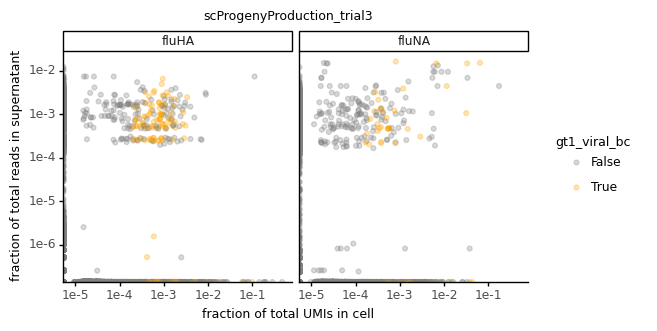

<ggplot: (8738040780867)>

In [29]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup',
                        color='gt1_viral_bc')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

#### Viral barcode rank in cell
I will rank each viral barcode in each cell-gene. I will see what fraction of all viral barcode UMIs each viral barcode accounts for.

To do this, I will:
* Group viral barcodes by cell-gene
* Sum fraction of cell UMIs that are assigned to **significant** viral barcodes in that cell-gene
* Rank only viral barcodes **that are significant above uninfected background**

Sum all **significant** viral bc freqs for each cell-gene:

In [30]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(
        cell_total_frac_viral_bc_UMIs=lambda x: x
                                                .query('reject_uninfected == True')
                                                .groupby(['cell_barcode',
                                                          'gene'])
                                                ['frac_viral_bc_UMIs']
                                                .transform('sum')))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN,False,NaN,False,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN,False,NaN,False,NaN
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN,False,NaN,False,NaN
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN,False,NaN,False,NaN
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,49137.0,10.0,NaN,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,4.057614e-03,NaN,NaN,NaN,False,NaN,False,NaN
15887,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,1.747121e-03,NaN,NaN,NaN,False,NaN,False,NaN
15888,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN
15889,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN


Calculate proportion of total significant viral bc UMI fraction in cell-gene that is derived from each significant viral bc:

In [31]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(
        prop_cell_viral_bc_UMIs=lambda x: x['frac_viral_bc_UMIs'] /
                                          x['cell_total_frac_viral_bc_UMIs']))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN,False,NaN,False,NaN,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN,False,NaN,False,NaN,NaN
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN,False,NaN,False,NaN,NaN
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN,False,NaN,False,NaN,NaN
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,49137.0,10.0,NaN,False,NaN,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,4.057614e-03,NaN,NaN,NaN,False,NaN,False,NaN,NaN
15887,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,1.747121e-03,NaN,NaN,NaN,False,NaN,False,NaN,NaN
15888,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN,NaN
15889,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN,NaN


Rank significant viral barcodes within each cell-gene:

In [32]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(viral_bc_rank=lambda x: x.groupby(['cell_barcode', 'gene'])
                                     ['prop_cell_viral_bc_UMIs']
                                     .rank('dense', ascending=False)))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN,False,NaN,False,NaN,NaN,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,NaN,20969.0,1.0,NaN,False,NaN,False,NaN,NaN,NaN
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN,False,NaN,False,NaN,NaN,NaN
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,NaN,39505.0,2.0,NaN,False,NaN,False,NaN,NaN,NaN
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,49137.0,10.0,NaN,False,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,4.057614e-03,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN
15887,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,1.747121e-03,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN
15888,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN
15889,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN


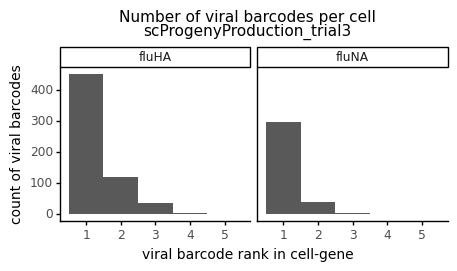

<ggplot: (8737370065764)>

In [33]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='viral_bc_rank'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('viral barcode rank in cell-gene') +
       p9.ylab('count of viral barcodes') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 14947 rows containing missing values.


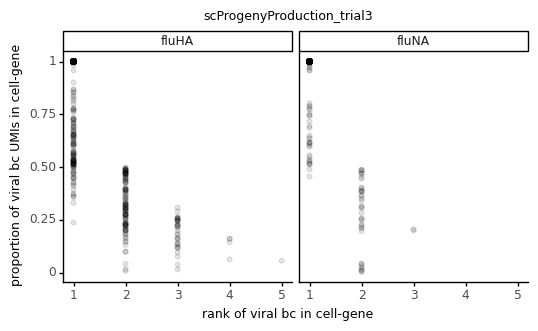

<ggplot: (8737369777107)>

In [34]:
fig = (p9.ggplot((viral_bc_freqs),
                 p9.aes(x='viral_bc_rank',
                        y='prop_cell_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='rank of viral bc in cell-gene',
               y='proportion of viral bc UMIs in cell-gene') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
      p9.scale_color_discrete(guide=False))
display(fig)

**Sanity check: viral rank vs number of viral barcodes per cell.**

The `n_significant_viral_bc_per_cell` histogram and `significant_viral_bc_rank_per_cell` histgoram do not look identical. I think some significant viral barcodes may be assigned duplicate ranks. I should check this and make sure it makes sense.

Result: Yes, sometimes low frequency viral barcodes in a cell have the same number of UMIs and get assigned identical ranks.

In [35]:
viral_bc_freqs.query('n_viral_bc > 3')

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank
4441,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,AAATATGAAACGATTT,81.0,0.002077,True,NaN,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.252336,3.0
4442,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,AACTATCGGAGTAACA,106.0,0.002719,True,NaN,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.330218,1.0
4444,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,GACCTTCTGAGAAAAC,18.0,0.000462,True,0.002546,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.056075,5.0
4446,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,GTGAGACGTGACTTTC,20.0,0.000513,True,0.000527,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.062305,4.0
4448,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,GTTTCTTCTTTTTTAG,96.0,0.002462,True,NaN,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.299065,2.0
5172,AACCAACGTCCAGTTA,True,wt,0.030916,fluHA,AATACCTCGCAGTAGT,30.0,0.000395,True,NaN,75980.0,2349.0,2.0,True,5.0,True,0.001724,0.229008,2.0
5173,AACCAACGTCCAGTTA,True,wt,0.030916,fluHA,ACGGAAAATCATAAAT,28.0,0.000369,True,0.000251,75980.0,2349.0,2.0,True,5.0,True,0.001724,0.213740,3.0
5174,AACCAACGTCCAGTTA,True,wt,0.030916,fluHA,ACGCGCTCTAGCATTG,21.0,0.000276,True,NaN,75980.0,2349.0,1.0,False,5.0,True,0.001724,0.160305,4.0
5176,AACCAACGTCCAGTTA,True,wt,0.030916,fluHA,CTCACTCATCCTTAAA,31.0,0.000408,True,NaN,75980.0,2349.0,1.0,False,5.0,True,0.001724,0.236641,1.0
5177,AACCAACGTCCAGTTA,True,wt,0.030916,fluHA,TTTGCCAGAAAATCTT,21.0,0.000276,True,NaN,75980.0,2349.0,1.0,False,5.0,True,0.001724,0.160305,4.0


#### Annotate most abundant viral barcode for each cell-gene:

In [36]:
viral_bc_freqs['top_viral_bc'] = (viral_bc_freqs['viral_bc_rank'] == 1)
viral_bc_freqs['top_viral_bc'].value_counts()

False    15146
True       745
Name: top_viral_bc, dtype: int64

#### Plot with most abundant viral barcode annotated:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


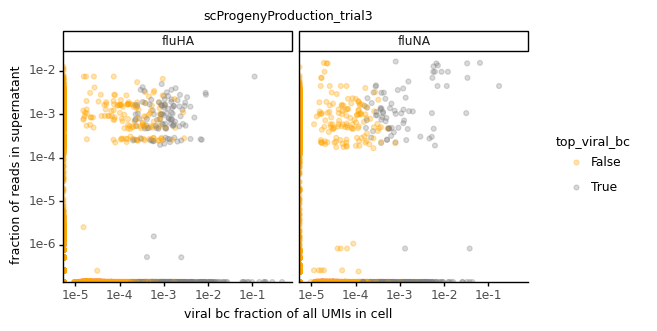

<ggplot: (8737369779179)>

In [37]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup',
                        color='top_viral_bc')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral bc fraction of all UMIs in cell',
               y='fraction of reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

#### Viral burden
Plot the viral burden (total fraction of viral UMIs in cell) against the supernatant frequency of the most abundant viral barcode for that cell.

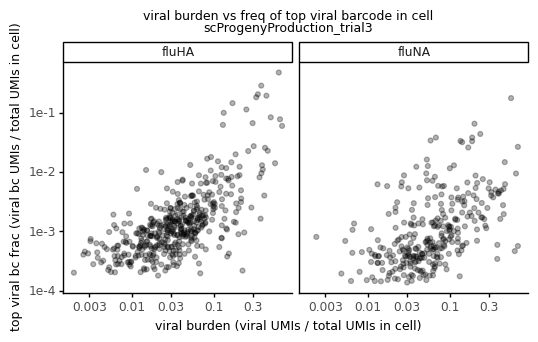

<ggplot: (8737385536142)>

In [38]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('(infected == True) and'
                        '(top_viral_bc == True)'),
                 p9.aes(x='frac_viral_UMIs',
                        y='frac_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle('viral burden vs freq of top viral barcode in cell\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell)',
               y='top viral bc frac (viral bc UMIs / total UMIs in cell)') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

**Total UMIs per cell**

Plot the frequency of the top viral barcode as a function of total UMIs in a cell

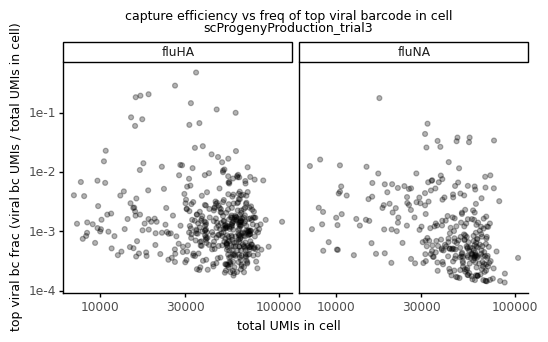

<ggplot: (8737369217558)>

In [39]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('(infected == True) and'
                        '(top_viral_bc == True)'),
                 p9.aes(x='total_UMIs',
                        y='frac_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle('capture efficiency vs freq of top viral barcode in cell\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='total UMIs in cell',
               y='top viral bc frac (viral bc UMIs / total UMIs in cell)') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot only the top viral barcode for each cell-gene:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


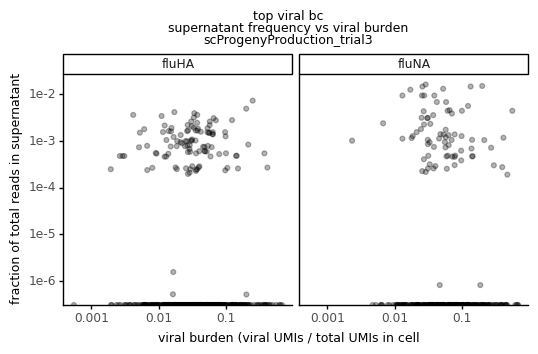

<ggplot: (8737385544659)>

In [40]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_sup')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'top viral bc\n'
                   'supernatant frequency vs viral burden\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

#### Correlation of fluHA and fluNA top viral barcodes in each cell
Check to see if cells associated with high fluHA also produce high fluNA values. 

First, pivot table so supernatant frequency of top fluHA viral barcode and top fluNA viral barcode are put in column alongside cell barcode. Fill NA values with zero because this means it was not observed in sequencing, so the frequency is meaningfully zero.

**Viral barcode transcription:**

In [41]:
high_transcription = (pd.pivot_table(
    viral_bc_freqs.query('top_viral_bc == True '),
    index=['cell_barcode',
           'infected',
           'infecting_viral_tag'],
    values='frac_viral_bc_UMIs',
    columns='gene')
                .reset_index()
                .fillna(0))

high_transcription

gene,cell_barcode,infected,infecting_viral_tag,fluHA,fluNA
0,AAACGAAGTACTTCCC,True,both,0.000000,0.005167
1,AAACGAAGTAGACGTG,True,wt,0.001731,0.000223
2,AAAGGATTCTGATGGT,True,syn,0.001017,0.007234
3,AAAGGGCCAGGCTACC,True,wt,0.001411,0.000470
4,AAAGGGCTCCGCACTT,True,wt,0.000218,0.000000
...,...,...,...,...,...
500,TTTAGTCGTGCTCCGA,True,wt,0.001559,0.000000
501,TTTCACAAGCCAAGCA,True,wt,0.004259,0.002974
502,TTTCGATTCAATCCAG,True,wt,0.000669,0.000000
503,TTTGATCTCGCATTGA,True,wt,0.001698,0.000000


Plot correlation:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


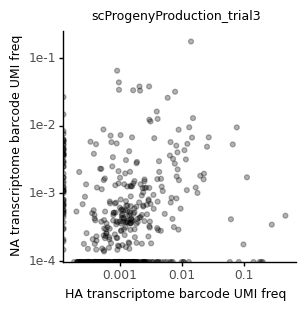

<ggplot: (8738040015463)>

In [42]:
fig = (p9.ggplot(high_transcription,
                 p9.aes(x='fluHA',
                        y='fluNA')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='HA transcriptome barcode UMI freq',
               y='NA transcriptome barcode UMI freq') +
       p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

**Supernatant progeny production:**

In [43]:
high_progeny = (pd.pivot_table(
    viral_bc_freqs.query('top_viral_bc == True '),
    index=['cell_barcode',
           'infected',
           'infecting_viral_tag'],
    values='freq_sup',
    columns='gene')
                .reset_index()
                .fillna(0))

high_progeny

gene,cell_barcode,infected,infecting_viral_tag,fluHA,fluNA
0,AAACGAAGTAGACGTG,True,wt,0.000287,0.000291
1,AAAGGATTCTGATGGT,True,syn,0.000000,0.013266
2,AAAGGGCTCCGCACTT,True,wt,0.000260,0.000000
3,AACAACCGTCTCTCTG,True,wt,0.003641,0.000000
4,AACCAACAGGGTCTTT,True,wt,0.000000,0.001061
...,...,...,...,...,...
133,TTGTTCAGTATGAGGC,True,wt,0.000266,0.000000
134,TTGTTTGCAACTCGAT,True,wt,0.000249,0.000000
135,TTTACCAGTCGCTTAA,True,wt,0.000465,0.000000
136,TTTCGATTCAATCCAG,True,wt,0.000536,0.000000


Plot correlation:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


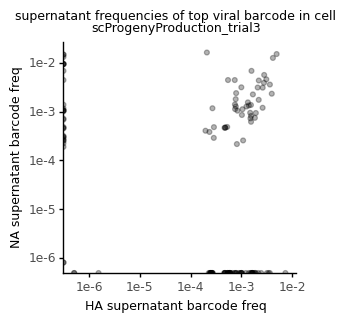

<ggplot: (8737369725838)>

In [44]:
fig = (p9.ggplot(high_progeny.
                 fillna(0),
                 p9.aes(x='fluHA',
                        y='fluNA')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle('supernatant frequencies of top viral barcode in cell\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='HA supernatant barcode freq',
               y='NA supernatant barcode freq') +
       p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

## Viral gene expression

#### Bulk viral gene expression 

Simply look at the read counts assigned to each viral gene in the BAM file.

In [45]:
bam_file = 'results/aligned_fastq10x/' + expt + '/Aligned.sortedByCoord.out.bam'
bam_file

idxstats_tsv = 'results/viral_fastq10x/' + expt + 'idxstats.tsv'
print(f'The BAM file being read is {bam_file}')
print(f'The contig stats will be stored in {idxstats_tsv}')

The BAM file being read is results/aligned_fastq10x/scProgenyProduction_trial3/Aligned.sortedByCoord.out.bam
The contig stats will be stored in results/viral_fastq10x/scProgenyProduction_trial3idxstats.tsv


In [46]:
cmd = ['samtools',
       'idxstats',
       bam_file]

with open(idxstats_tsv, 'w') as f:
    subprocess.check_call(cmd, stdout=f)

with open(idxstats_tsv, 'r') as f:
    bulk_gex = pd.read_csv(f, sep='\t', header=None)
    bulk_gex.rename(columns={0:'ref_id',
                             1:'contig_len',
                             2:'mapped_reads',
                             3:'unmapped_reads'},
                    inplace=True)

bulk_gex

,ref_id,contig_len,mapped_reads,unmapped_reads
0,1,122678785,14219171,0
1,2,85426708,9434773,0
2,3,91889043,6730404,0
3,4,88276631,6284541,0
4,5,88915250,9415903,0
...,...,...,...,...
3272,fluNP,1565,344491,0
3273,fluNA,1735,95284,0
3274,fluM,1027,701982,0
3275,fluNS,890,555038,0


In [47]:
bulk_gex.query(f'ref_id in {viral_genes}')

,ref_id,contig_len,mapped_reads,unmapped_reads
3268,fluPB2,2341,28552,0
3269,fluPB1,2341,86853,0
3270,fluPA,2233,9879,0
3271,fluHA,2035,226522,0
3272,fluNP,1565,344491,0
3273,fluNA,1735,95284,0
3274,fluM,1027,701982,0
3275,fluNS,890,555038,0


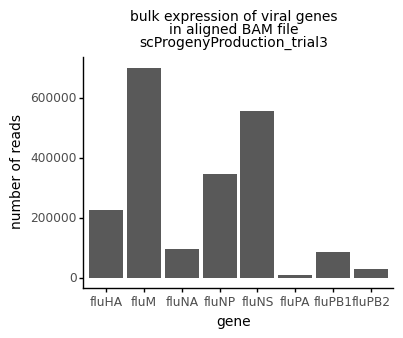

<ggplot: (8737369740557)>

In [48]:
fig = (p9.ggplot((bulk_gex.query(f'ref_id in {viral_genes}')),
                  p9.aes(x='factor(ref_id)',
                         y='mapped_reads')) +
              p9.geom_bar(stat='identity') +
              p9.ggtitle('bulk expression of viral genes\n'
                         'in aligned BAM file\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('number of reads') +
              p9.theme(figure_size=(4, 3),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_x_discrete())
display(fig)

#### Viral genes in each cell
Extract the UMI counts for each viral gene in each cell from `adata.obs`

In [49]:
#### Viral genes in each cell
viral_gene_expression = (
    adata.var
    .assign(total_UMIs=numpy.sum(adata.X, axis=0).A1.astype(int),
            viral_UMIs=numpy.sum(adata[adata.obs['gene']
                                   .isin(viral_genes), ].X,
                                 axis=0).A1.astype(int),
            fluPB2=numpy.sum(adata[adata.obs['gene'] == 'fluPB2', ]
                             .X, axis=0).A1.astype(int),
            fluPB1=numpy.sum(adata[adata.obs['gene'] == 'fluPB1', ]
                             .X, axis=0).A1.astype(int),
            fluPA=numpy.sum(adata[adata.obs['gene'] == 'fluPA', ]
                             .X, axis=0).A1.astype(int),
            fluHA=numpy.sum(adata[adata.obs['gene'] == 'fluHA', ]
                             .X, axis=0).A1.astype(int),
            fluNP=numpy.sum(adata[adata.obs['gene'] == 'fluNP', ]
                             .X, axis=0).A1.astype(int),
            fluNA=numpy.sum(adata[adata.obs['gene'] == 'fluNA', ]
                             .X, axis=0).A1.astype(int),
            fluM=numpy.sum(adata[adata.obs['gene'] == 'fluM', ]
                             .X, axis=0).A1.astype(int),
            fluNS=numpy.sum(adata[adata.obs['gene'] == 'fluNS', ]
                             .X, axis=0).A1.astype(int),
           )
)

viral_gene_expression

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,cell_barcode,total_UMIs,viral_UMIs,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS
0,AAACCCAGTAACAAGT,20969,1,0,0,0,0,0,0,1,0
1,AAACCCATCATTGCTT,39505,2,1,0,0,1,0,0,0,0
2,AAACGAAAGATGTTGA,49137,10,0,0,0,0,0,0,6,4
3,AAACGAAGTACTTCCC,25547,11452,78,232,8,1,1780,192,6276,2885
4,AAACGAAGTAGACGTG,53719,2155,2,17,4,142,286,13,708,983
...,...,...,...,...,...,...,...,...,...,...,...
3363,TTTGATCTCCCGTTCA,27511,3,0,0,0,0,1,0,1,1
3364,TTTGATCTCGCATTGA,73596,4648,13,46,3,257,526,496,2251,1056
3365,TTTGGAGAGTTGCCTA,28413,2,0,0,0,0,1,0,1,0
3366,TTTGGAGGTATCGTTG,65134,1598,5,29,2,39,188,17,750,568


Bring in infection status and tag information:

In [50]:
viral_gene_expression = pd.merge(
    left=viral_gene_expression,
    right=(viral_bc_freqs
           .query('cell_barcode.notnull()',
                  engine='python')
           [['cell_barcode',
             'infected',
             'infecting_viral_tag']]
           .drop_duplicates()),
    on='cell_barcode',
    how='left',
    validate='one_to_one'
    )

viral_gene_expression

,cell_barcode,total_UMIs,viral_UMIs,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS,infected,infecting_viral_tag
0,AAACCCAGTAACAAGT,20969,1,0,0,0,0,0,0,1,0,False,none
1,AAACCCATCATTGCTT,39505,2,1,0,0,1,0,0,0,0,False,none
2,AAACGAAAGATGTTGA,49137,10,0,0,0,0,0,0,6,4,False,none
3,AAACGAAGTACTTCCC,25547,11452,78,232,8,1,1780,192,6276,2885,True,both
4,AAACGAAGTAGACGTG,53719,2155,2,17,4,142,286,13,708,983,True,wt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363,TTTGATCTCCCGTTCA,27511,3,0,0,0,0,1,0,1,1,False,none
3364,TTTGATCTCGCATTGA,73596,4648,13,46,3,257,526,496,2251,1056,True,wt
3365,TTTGGAGAGTTGCCTA,28413,2,0,0,0,0,1,0,1,0,False,none
3366,TTTGGAGGTATCGTTG,65134,1598,5,29,2,39,188,17,750,568,True,wt


Pivot the table so that gene is a column, and the UMI counts for each gene for each cell is a row

In [51]:
viral_gene_expression_long = viral_gene_expression.melt(
    id_vars=['cell_barcode',
             'infected',
             'infecting_viral_tag',
             'total_UMIs',
             'viral_UMIs'],
    var_name='gene',
    value_name='gene_UMIs'
)

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0
1,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1
2,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0
3,AAACGAAGTACTTCCC,True,both,25547,11452,fluPB2,78
4,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPB2,2
...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,fluNS,1
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,fluNS,1056
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568


Check that total number of rows is = total number of cells * total number of genes, for both infected and uninfected:

In [52]:
assert (len(viral_gene_expression_long) ==
        len(viral_gene_expression_long['cell_barcode'].drop_duplicates()) *
        len(viral_genes)), "not 8 genes for every cell"

Check that the extracted gene_UMIs sum to the total viral UMIs for each cell:

In [53]:
pd.testing.assert_frame_equal(
    (viral_gene_expression_long[['cell_barcode',
                                 'viral_UMIs']]
     .drop_duplicates()),
    (viral_gene_expression_long
     .groupby('cell_barcode')
     ['gene_UMIs']
     .sum()
     .to_frame()
     .reset_index()
     .rename(columns={'gene_UMIs': 'viral_UMIs'})),
    check_names=False,
    check_index_type=False
)

Calculate the fraction of all UMIs assigned to each viral gene individually, and in aggregate:

In [54]:
viral_gene_expression_long['frac_viral_UMIs'] = (
    viral_gene_expression_long['viral_UMIs'] /
    viral_gene_expression_long['total_UMIs'])

viral_gene_expression_long['frac_gene_UMIs'] = (
    viral_gene_expression_long['gene_UMIs'] /
    viral_gene_expression_long['total_UMIs'])

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000
1,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1,0.000051,0.000025
2,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0,0.000204,0.000000
3,AAACGAAGTACTTCCC,True,both,25547,11452,fluPB2,78,0.448272,0.003053
4,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPB2,2,0.040116,0.000037
...,...,...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,fluNS,1,0.000109,0.000036
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,fluNS,1056,0.063156,0.014349
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0,0.000070,0.000000
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568,0.024534,0.008720


Plot distribution of absolute UMI counts for each gene:

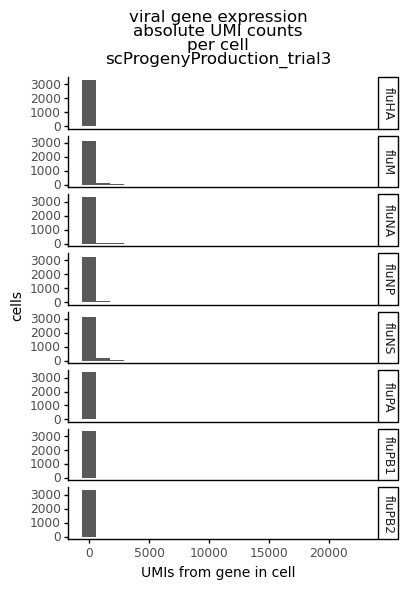

<ggplot: (8737371712509)>

In [55]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'absolute UMI counts\n'
                  'per cell\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='cells') +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot on log scale:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 16097 rows containing non-finite values.


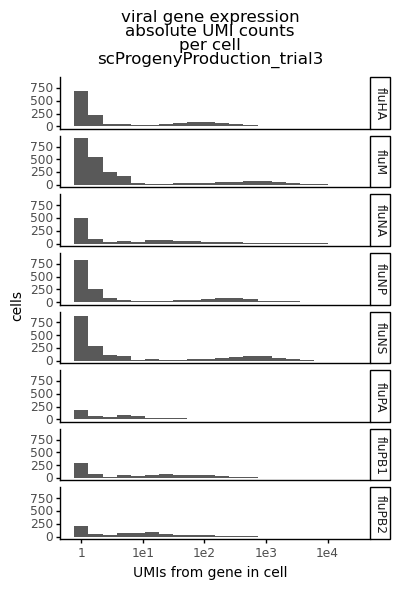

<ggplot: (8737370068721)>

In [56]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'absolute UMI counts\n'
                  'per cell\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot distribution of fraction of UMIs from each viral gene:

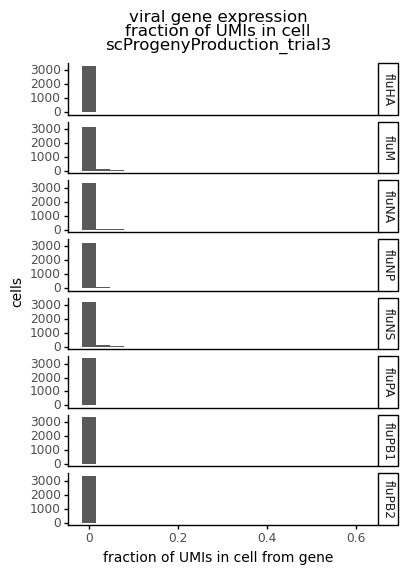

<ggplot: (8737369842565)>

In [57]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs in cell\n'
                  f'{expt}') +
       p9.labs(x='fraction of UMIs in cell from gene',
               y='cells') +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot on log scale:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 16097 rows containing non-finite values.


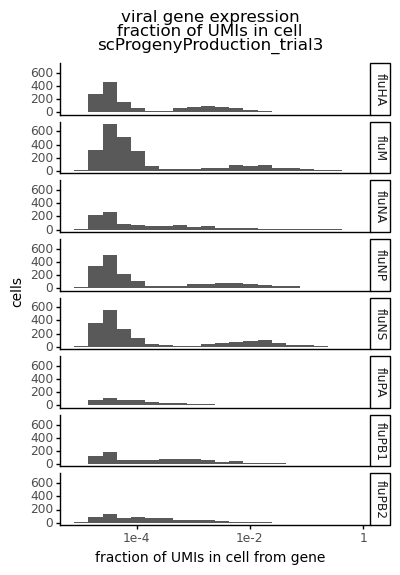

<ggplot: (8737368993880)>

In [58]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs in cell\n'
                  f'{expt}') +
       p9.labs(x='fraction of UMIs in cell from gene',
               y='cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

What is the relationship between absolute UMI counts and fraction of all UMIs in cell for each gene?

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


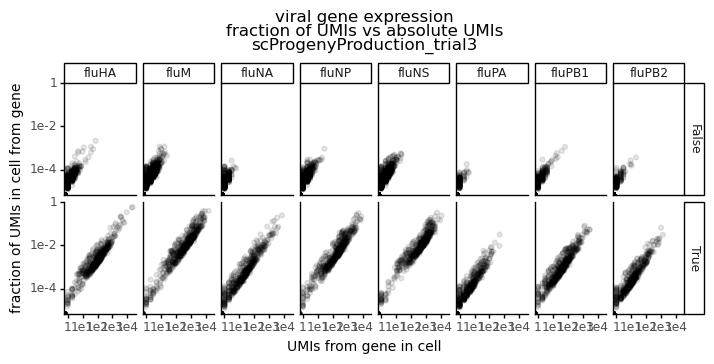

<ggplot: (8738040805777)>

In [59]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs',
                        y='frac_gene_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs vs absolute UMIs\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='fraction of UMIs in cell from gene') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(8, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Distribution of viral gene expression in infected and **uninfected** cells:

**N.b.** Plot 0 values on far left of axis, 100-fold lower than lowest real value:

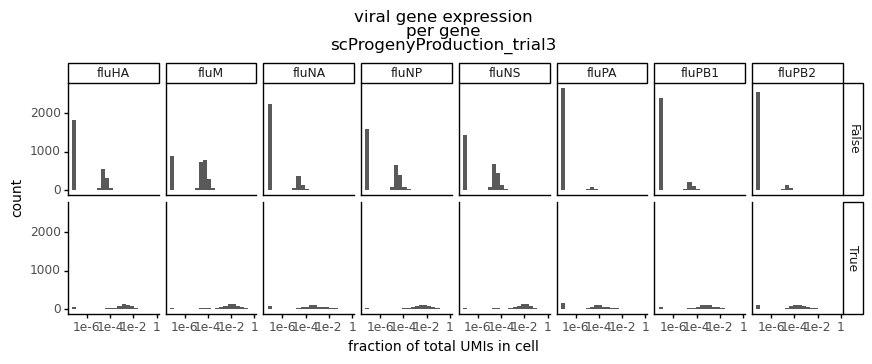

<ggplot: (8737385509000)>

In [60]:
zero_pseudocount = (min(viral_gene_expression_long
                        .query('frac_gene_UMIs > 0')
                        ['frac_gene_UMIs']) /
                    100)
zero_pseudocount

fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 16097 rows containing non-finite values.


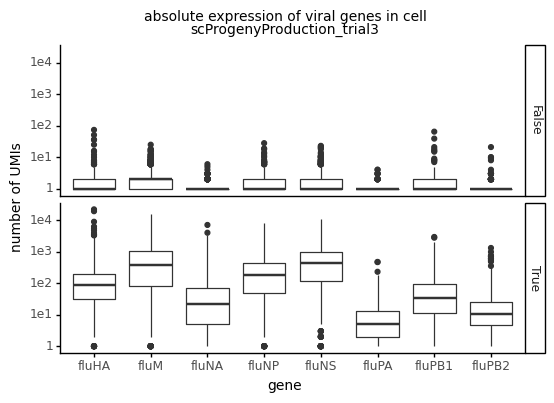

<ggplot: (8737369184503)>

In [61]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='gene_UMIs')) +
              p9.geom_boxplot() +
              p9.facet_grid('infected~') +
              p9.ggtitle('absolute expression of viral genes in cell\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('number of UMIs') +
              p9.scale_y_log10() +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 16097 rows containing non-finite values.


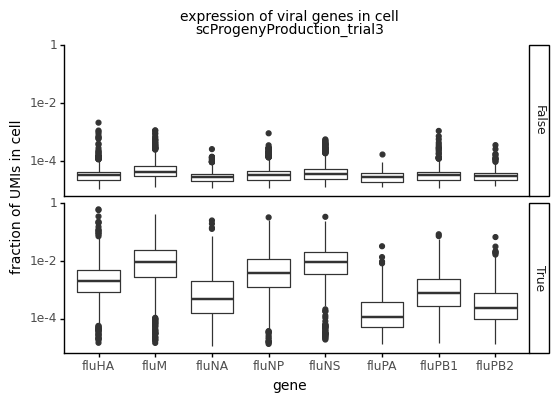

<ggplot: (8737370085298)>

In [62]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='frac_gene_UMIs')) +
              p9.geom_boxplot() +
              p9.facet_grid('infected~') +
              p9.ggtitle('expression of viral genes in cell\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('fraction of UMIs in cell') +
              p9.scale_y_log10() +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center'))
display(fig)

#### Proportion of viral UMIs from each gene

Next, within each cell, I will calculate the proportion of all viral UMIs derived from each gene. 

In [63]:
viral_gene_expression_long['prop_viral_UMIs'] = (
    viral_gene_expression_long['gene_UMIs'] /
    viral_gene_expression_long['viral_UMIs']
)

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000,0.000000
1,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1,0.000051,0.000025,0.500000
2,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0,0.000204,0.000000,0.000000
3,AAACGAAGTACTTCCC,True,both,25547,11452,fluPB2,78,0.448272,0.003053,0.006811
4,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPB2,2,0.040116,0.000037,0.000928
...,...,...,...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,fluNS,1,0.000109,0.000036,0.333333
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,fluNS,1056,0.063156,0.014349,0.227194
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0,0.000070,0.000000,0.000000
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568,0.024534,0.008720,0.355444


Check that the proportion sums to 1 for every cell:

In [64]:
test_prop_sum_df = pd.merge(
    left=viral_gene_expression_long,
    right=(viral_gene_expression_long
           .groupby('cell_barcode')
           ['prop_viral_UMIs']
           .sum()
           .round(4)),
    suffixes=[None,'_sum'],
    on='cell_barcode',
)

test_prop_sum_df['sum_OK'] = test_prop_sum_df.apply(
    lambda x: (x['prop_viral_UMIs_sum'] == 1) or (x['viral_UMIs'] == 0),
    axis=1)
                              
assert (test_prop_sum_df['sum_OK'] == True).all(), \
    "problem summing viral gene proportions"

test_prop_sum_df


,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs,prop_viral_UMIs_sum,sum_OK
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000,0.00,1.0,True
1,AAACCCAGTAACAAGT,False,none,20969,1,fluPB1,0,0.000048,0.000000,0.00,1.0,True
2,AAACCCAGTAACAAGT,False,none,20969,1,fluPA,0,0.000048,0.000000,0.00,1.0,True
3,AAACCCAGTAACAAGT,False,none,20969,1,fluHA,0,0.000048,0.000000,0.00,1.0,True
4,AAACCCAGTAACAAGT,False,none,20969,1,fluNP,0,0.000048,0.000000,0.00,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
26939,TTTGTTGAGTGCAGCA,False,none,58559,4,fluHA,1,0.000068,0.000017,0.25,1.0,True
26940,TTTGTTGAGTGCAGCA,False,none,58559,4,fluNP,0,0.000068,0.000000,0.00,1.0,True
26941,TTTGTTGAGTGCAGCA,False,none,58559,4,fluNA,0,0.000068,0.000000,0.00,1.0,True
26942,TTTGTTGAGTGCAGCA,False,none,58559,4,fluM,1,0.000068,0.000017,0.25,1.0,True


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 1672 rows containing non-finite values.


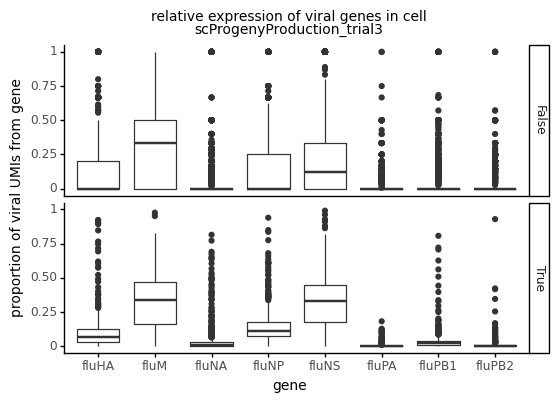

<ggplot: (8737369346967)>

In [65]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='prop_viral_UMIs')) +
              p9.geom_boxplot() +
              p9.ggtitle('relative expression of viral genes in cell\n'
                         f'{expt}') +
              p9.facet_grid('infected~') +
              p9.xlab('gene') +
              p9.ylab('proportion of viral UMIs from gene') +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center'))
display(fig)

### Call presence/absence of viral genes

Next I will extract the 90th percentile value from the uninfected cells. We were very conservative in calling cells as infected (likely there are some infected cells in the population labelled "uninfected"). A priori, we expect most infected cells to express most viral genes. So we can be more lenient in what we use as a cutoff in calling a gene present. In some previous analyses [Russel et al. 2018](https://elifesciences.org/articles/32303) a single transcript was used to call the presence of a gene in infected cells.

In [66]:
limit_percentile = 0.90
limit = dict()

for gene in viral_genes:
    limit[gene] = (viral_gene_expression_long
                   .query('(infecting_viral_tag == "none") '
                          f'and (gene == "{gene}")')
                   ['frac_gene_UMIs']
                   .quantile(limit_percentile))

limit = pd.DataFrame.from_dict(limit, orient='index')
limit = limit.reset_index()
limit = limit.rename(columns={0: 'limit_frac',
                              'index': 'gene'})

# Replace limits of value 0 with minimum
limit = (
    limit
    .replace(
        to_replace={'limit_frac':0},
        value=min(limit
                  .query('limit_frac > 0')
                  ['limit_frac'])))

limit

,gene,limit_frac
0,fluPB2,0.000022
1,fluPB1,0.000022
2,fluPA,0.000022
3,fluHA,0.000042
4,fluNA,0.000028
5,fluNP,0.000049
6,fluM,0.000090
7,fluNS,0.000063


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 16097 rows containing non-finite values.


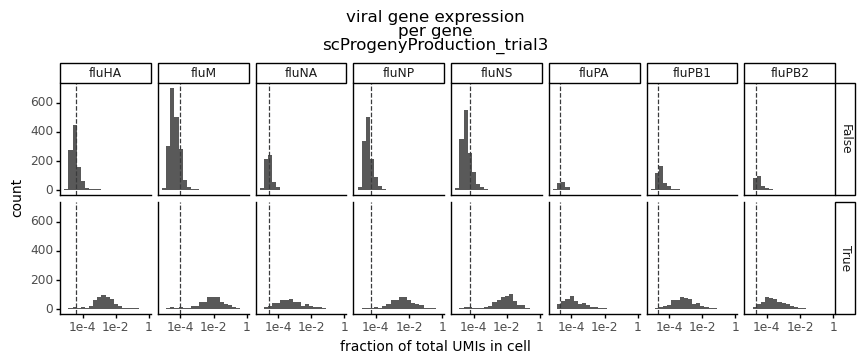

<ggplot: (8737369267592)>

In [67]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.geom_vline(limit,
                     p9.aes(xintercept='limit_frac'),
                     linetype='dashed',
                     color='#3A3B3C',
                     size=0.5) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

Build a poisson distribution around this value. I will perform a statistical test to see if the value seen for each gene in infected cells falls within this distribution or rejects the null hypothesis.

Now calculate the expected number of UMIs for each gene using this upper bound limit. For every cell and gene, I will simply multiply the total number of UMIs by this limit value.

In [68]:
viral_gene_expression_long = pd.merge(
    left=viral_gene_expression_long,
    right=limit,
    on=['gene'],
    how='left'
    )

Calculate the expected number of UMIs corresponding to this 90th percentile proportion for each cell.

In [69]:
viral_gene_expression_long['limit_UMIs'] = (viral_gene_expression_long['total_UMIs'] *
                                            viral_gene_expression_long['limit_frac'])
viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs,limit_frac,limit_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000,0.000000,0.000022,0.463431
1,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1,0.000051,0.000025,0.500000,0.000022,0.873091
2,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0,0.000204,0.000000,0.000000,0.000022,1.085966
3,AAACGAAGTACTTCCC,True,both,25547,11452,fluPB2,78,0.448272,0.003053,0.006811,0.000022,0.564609
4,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPB2,2,0.040116,0.000037,0.000928,0.000022,1.187232
...,...,...,...,...,...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,fluNS,1,0.000109,0.000036,0.333333,0.000063,1.738910
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,fluNS,1056,0.063156,0.014349,0.227194,0.000063,4.651841
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0,0.000070,0.000000,0.000000,0.000063,1.795923
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568,0.024534,0.008720,0.355444,0.000063,4.116977


Calculate the p-value that a gene is present above the background distribution (poisson distribution with mu = `limit_UMIs`).

In [70]:
p_cutoff = 0.05

viral_gene_expression_long['null_P'] = (
    1 - scipy.stats.poisson.cdf(
        k=viral_gene_expression_long['gene_UMIs'],
        mu=viral_gene_expression_long['limit_UMIs']))

viral_gene_expression_long['gene_present'] = (viral_gene_expression_long['null_P']
                                              < p_cutoff)

viral_gene_expression_long.query('gene == "fluPA"')

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs,limit_frac,limit_UMIs,null_P,gene_present
6736,AAACCCAGTAACAAGT,False,none,20969,1,fluPA,0,0.000048,0.000000,0.000000,0.000022,0.463431,3.708787e-01,False
6737,AAACCCATCATTGCTT,False,none,39505,2,fluPA,0,0.000051,0.000000,0.000000,0.000022,0.873091,5.823415e-01,False
6738,AAACGAAAGATGTTGA,False,none,49137,10,fluPA,0,0.000204,0.000000,0.000000,0.000022,1.085966,6.624244e-01,False
6739,AAACGAAGTACTTCCC,True,both,25547,11452,fluPA,8,0.448272,0.000313,0.000699,0.000022,0.564609,9.679634e-09,True
6740,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPA,4,0.040116,0.000074,0.001856,0.000022,1.187232,7.418438e-03,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10099,TTTGATCTCCCGTTCA,False,none,27511,3,fluPA,0,0.000109,0.000000,0.000000,0.000022,0.608014,4.555692e-01,False
10100,TTTGATCTCGCATTGA,True,wt,73596,4648,fluPA,3,0.063156,0.000041,0.000645,0.000022,1.626529,8.251214e-02,False
10101,TTTGGAGAGTTGCCTA,False,none,28413,2,fluPA,0,0.000070,0.000000,0.000000,0.000022,0.627949,4.663149e-01,False
10102,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluPA,2,0.024534,0.000031,0.001252,0.000022,1.439512,1.761297e-01,False


Plot the proportion of viral UMIs from each gene against the p value for every cell:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


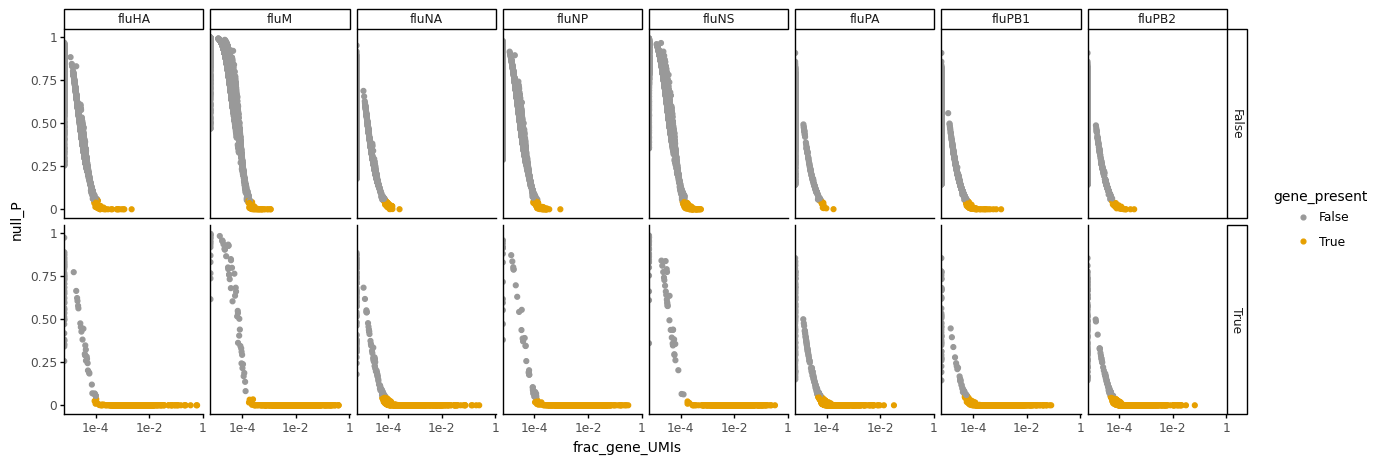

<ggplot: (8737371670477)>

In [71]:
fig = (p9.ggplot((viral_gene_expression_long),
                 p9.aes(x='frac_gene_UMIs',
                        y='null_P',
                        color='gene_present')) +
       p9.geom_point() +
       p9.facet_grid('infected~gene') +
       p9.theme(figure_size=(15, 5),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE[0:]) +
       p9.scale_x_log10()
       )
display(fig)

Color the proportion histogram by present/absent call:

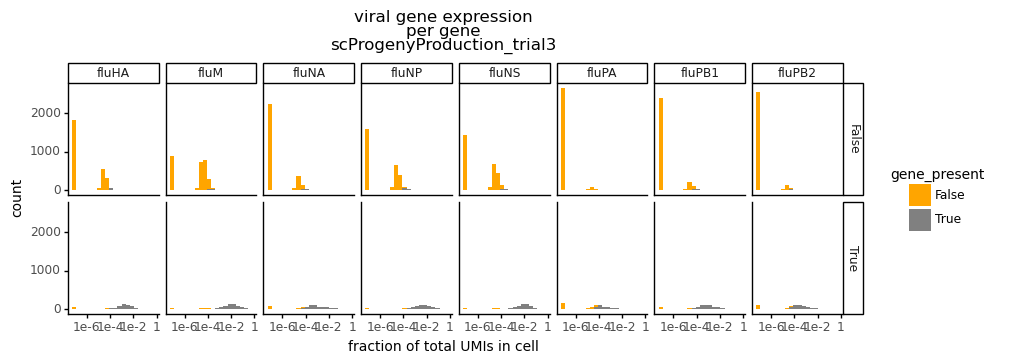

<ggplot: (8737369188633)>

In [72]:
fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs',
                        fill='gene_present')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10() +
       p9.scale_fill_manual(values=['orange','grey'])
       )
display(fig)

Annotate the fraction of cells that have each viral gene:

In [73]:
has_gene = pd.DataFrame(
    viral_gene_expression_long
    .groupby(['infected',
              'infecting_viral_tag',
              'gene'])
    ['gene_present']
    .value_counts(normalize=True)
    .reset_index(name='prop_cells'))

has_gene

,infected,infecting_viral_tag,gene,gene_present,prop_cells
0,False,none,fluHA,False,0.979899
1,False,none,fluHA,True,0.020101
2,False,none,fluM,False,0.978105
3,False,none,fluM,True,0.021895
4,False,none,fluNA,False,0.987796
...,...,...,...,...,...
58,True,wt,fluPA,False,0.448649
59,True,wt,fluPB1,True,0.864865
60,True,wt,fluPB1,False,0.135135
61,True,wt,fluPB2,True,0.754054


Plot this fraction for each gene and infecting viral tag:

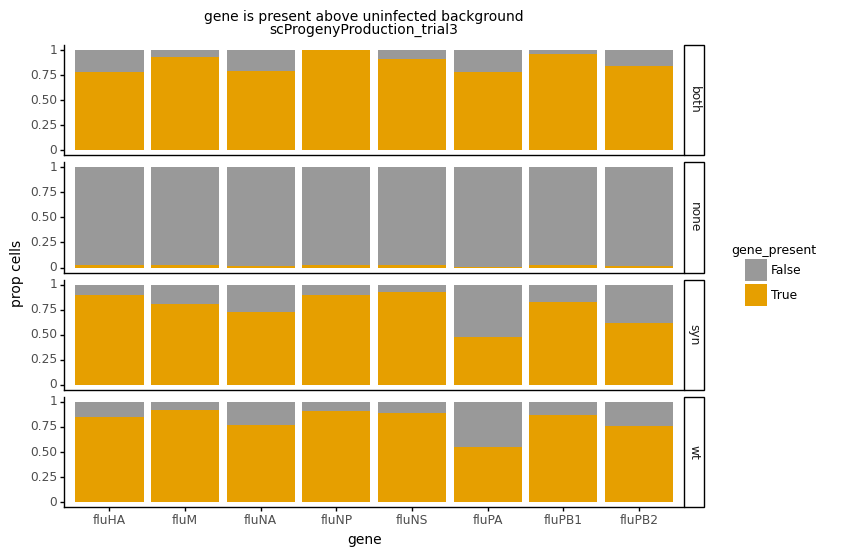

<ggplot: (8737369777288)>

In [74]:
fig = (p9.ggplot((has_gene),
                  p9.aes(x='gene',
                         y='prop_cells',
                         fill='gene_present')) +
              p9.geom_bar(stat='identity') +
              p9.ggtitle('gene is present above uninfected background\n'
                         f'{expt}') +
              p9.ylab('prop cells') +
              p9.facet_grid('infecting_viral_tag~') +
              p9.theme(figure_size=(8, 6),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Tabulate the number of viral genes present in each cell

In [75]:
n_viral_genes = (pd.pivot_table(
    viral_gene_expression_long,
    index=['cell_barcode',
           'infected',
           'infecting_viral_tag',
           'total_UMIs'],
    values='gene_present',
    aggfunc=numpy.sum)
                 .reset_index()
                 .rename(columns={'gene_present':'n_viral_genes_present'}))

n_viral_genes

,cell_barcode,infected,infecting_viral_tag,total_UMIs,n_viral_genes_present
0,AAACCCAGTAACAAGT,False,none,20969,0
1,AAACCCATCATTGCTT,False,none,39505,0
2,AAACGAAAGATGTTGA,False,none,49137,0
3,AAACGAAGTACTTCCC,True,both,25547,7
4,AAACGAAGTAGACGTG,True,wt,53719,7
...,...,...,...,...,...
3363,TTTGATCTCCCGTTCA,False,none,27511,0
3364,TTTGATCTCGCATTGA,True,wt,73596,7
3365,TTTGGAGAGTTGCCTA,False,none,28413,0
3366,TTTGGAGGTATCGTTG,True,wt,65134,7


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


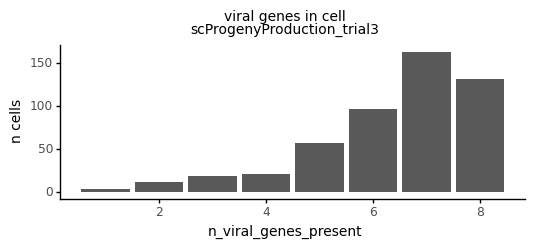

<ggplot: (8738040039717)>

In [76]:
fig = (p9.ggplot((n_viral_genes
                  .query('infected == True and '
                         'infecting_viral_tag != "both"')),
                  p9.aes(x='n_viral_genes_present')) +
              p9.geom_bar(stat='count') +
              p9.ggtitle('viral genes in cell\n'
                         f'{expt}') +
              p9.ylab('n cells') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Add this information to viral_bc_freqs dataframe

In [77]:
viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=n_viral_genes,
    on=['cell_barcode',
        'infected',
        'infecting_viral_tag'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup,...,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank,top_viral_bc,total_UMIs_y,n_viral_genes_present
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,...,NaN,False,NaN,False,NaN,NaN,NaN,False,20969.0,0.0
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,NaN,...,NaN,False,NaN,False,NaN,NaN,NaN,False,20969.0,0.0
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,...,NaN,False,NaN,False,NaN,NaN,NaN,False,39505.0,0.0
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,NaN,...,NaN,False,NaN,False,NaN,NaN,NaN,False,39505.0,0.0
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,...,NaN,False,NaN,False,NaN,NaN,NaN,False,49137.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,4.057614e-03,...,NaN,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN
15887,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,1.747121e-03,...,NaN,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN
15888,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,2.399886e-07,...,NaN,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN
15889,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,2.399886e-07,...,NaN,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN


### Viral gene expression as a function of viral burden

Plot relationship between n viral genes and viral burden

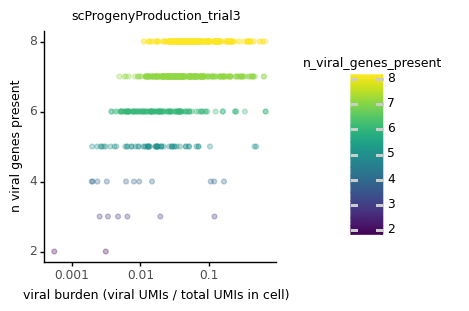

<ggplot: (8738040718352)>

In [78]:
fig = (p9.ggplot(viral_bc_freqs.query('top_viral_bc == True'),
                 p9.aes(x='frac_viral_UMIs',
                        y='n_viral_genes_present',
                        color='n_viral_genes_present')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell)',
               y='n viral genes present') +
       p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot relationship between n viral genes and viral progeny production in sup

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 560 rows containing missing values.


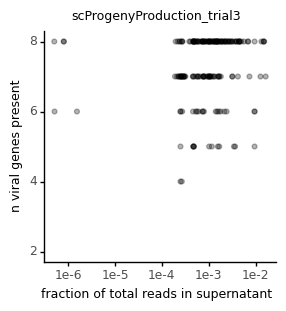

<ggplot: (8737369491734)>

In [79]:
fig = (p9.ggplot((viral_bc_freqs
                 .query('top_viral_bc == True')),
                 p9.aes(x='freq_sup',
                        y='n_viral_genes_present')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.labs(x='fraction of total reads in supernatant',
               y='n viral genes present') +
       p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Color the transcription-progeny plot by the number of viral genes present

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


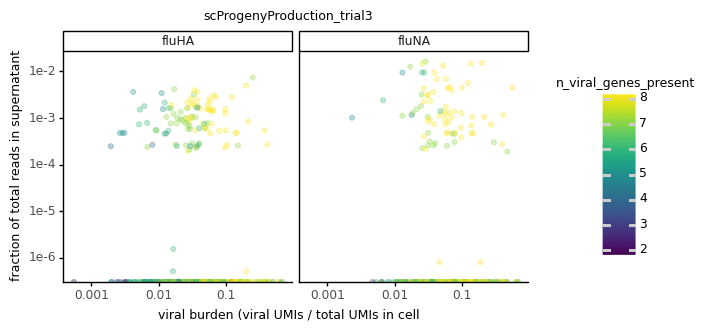

<ggplot: (8737369491890)>

In [80]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_sup',
                        color='n_viral_genes_present')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

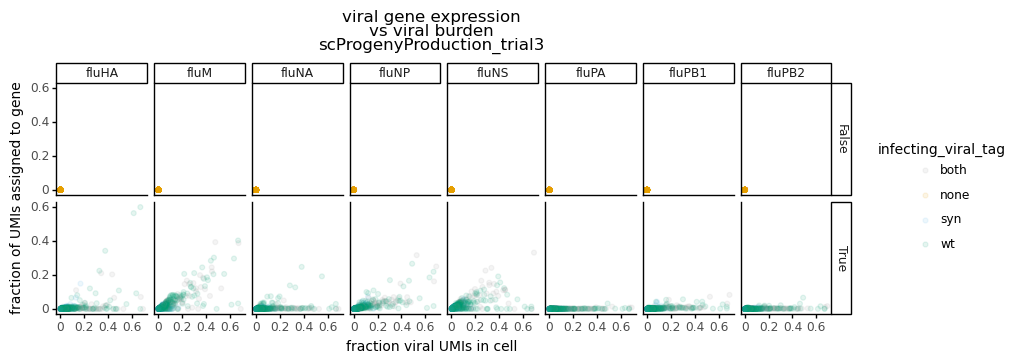

<ggplot: (8737371668788)>

In [81]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_viral_UMIs',
                        y='frac_gene_UMIs',
                        color='infecting_viral_tag')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'vs viral burden\n'
                  f'{expt}') +
       p9.labs(x='fraction viral UMIs in cell',
               y='fraction of UMIs assigned to gene') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE[0:]))
display(fig)

Check to see how viral gene presence/absence relates to the total number of UMIs generated for that cell to assess capture:

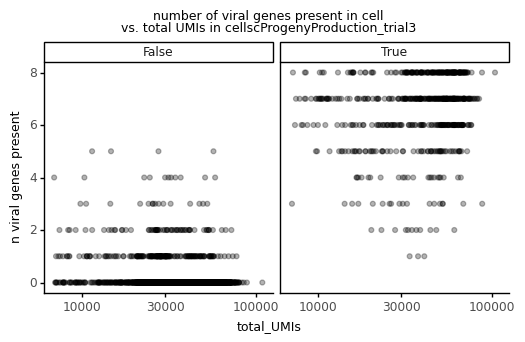

<ggplot: (8737364134846)>

In [82]:
fig = (p9.ggplot(n_viral_genes,
                 p9.aes(x='total_UMIs',
                        y='n_viral_genes_present')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~infected') +
       p9.ggtitle(f'number of viral genes present in cell\n'
                  f'vs. total UMIs in cell'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.labs(x='total_UMIs',
               y='n viral genes present') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Annotate cells that have all genes:

In [83]:
n_viral_genes['all_genes'] = (n_viral_genes['n_viral_genes_present'] == 8)
n_viral_genes

,cell_barcode,infected,infecting_viral_tag,total_UMIs,n_viral_genes_present,all_genes
0,AAACCCAGTAACAAGT,False,none,20969,0,False
1,AAACCCATCATTGCTT,False,none,39505,0,False
2,AAACGAAAGATGTTGA,False,none,49137,0,False
3,AAACGAAGTACTTCCC,True,both,25547,7,False
4,AAACGAAGTAGACGTG,True,wt,53719,7,False
...,...,...,...,...,...,...
3363,TTTGATCTCCCGTTCA,False,none,27511,0,False
3364,TTTGATCTCGCATTGA,True,wt,73596,7,False
3365,TTTGGAGAGTTGCCTA,False,none,28413,0,False
3366,TTTGGAGGTATCGTTG,True,wt,65134,7,False


Add this info to viral_bc_freqs

In [84]:
viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=n_viral_genes,
    on=['cell_barcode',
        'infected',
        'infecting_viral_tag',
        'n_viral_genes_present'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup,...,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank,top_viral_bc,total_UMIs_y,n_viral_genes_present,total_UMIs,all_genes
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,...,NaN,False,NaN,NaN,NaN,False,20969.0,0.0,20969.0,False
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,NaN,...,NaN,False,NaN,NaN,NaN,False,20969.0,0.0,20969.0,False
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,...,NaN,False,NaN,NaN,NaN,False,39505.0,0.0,39505.0,False
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,NaN,...,NaN,False,NaN,NaN,NaN,False,39505.0,0.0,39505.0,False
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,...,NaN,False,NaN,NaN,NaN,False,49137.0,0.0,49137.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,4.057614e-03,...,NaN,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
15887,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,1.747121e-03,...,NaN,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
15888,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,2.399886e-07,...,NaN,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
15889,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,2.399886e-07,...,NaN,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


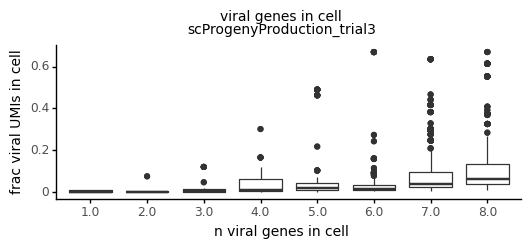

<ggplot: (8737369051097)>

In [85]:
fig = (p9.ggplot((viral_bc_freqs
                  .query('infected == True and '
                         'infecting_viral_tag != "both"')),
                  p9.aes(x='factor(n_viral_genes_present)',
                         y='frac_viral_UMIs')) +
              p9.geom_boxplot() +
              p9.ggtitle('viral genes in cell\n'
                         f'{expt}') +
              p9.xlab('n viral genes in cell') +
              p9.ylab('frac viral UMIs in cell') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Plot transcription vs progeny, annotated by complete genome:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


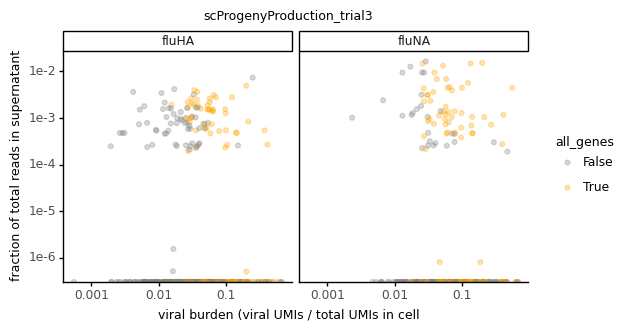

<ggplot: (8737369752191)>

In [86]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_sup',
                        color='all_genes')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

#### Annotate whether cells contribute progeny

In [87]:
viral_bc_freqs['contribute_progeny'] = (viral_bc_freqs['freq_sup'] > 0)
viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,freq_sup,...,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank,top_viral_bc,total_UMIs_y,n_viral_genes_present,total_UMIs,all_genes,contribute_progeny
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,...,False,NaN,NaN,NaN,False,20969.0,0.0,20969.0,False,False
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,NaN,...,False,NaN,NaN,NaN,False,20969.0,0.0,20969.0,False,False
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,...,False,NaN,NaN,NaN,False,39505.0,0.0,39505.0,False,False
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,NaN,...,False,NaN,NaN,NaN,False,39505.0,0.0,39505.0,False,False
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,...,False,NaN,NaN,NaN,False,49137.0,0.0,49137.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,4.057614e-03,...,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,True
15887,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,1.747121e-03,...,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,True
15888,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,2.399886e-07,...,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,True
15889,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,2.399886e-07,...,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,True


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


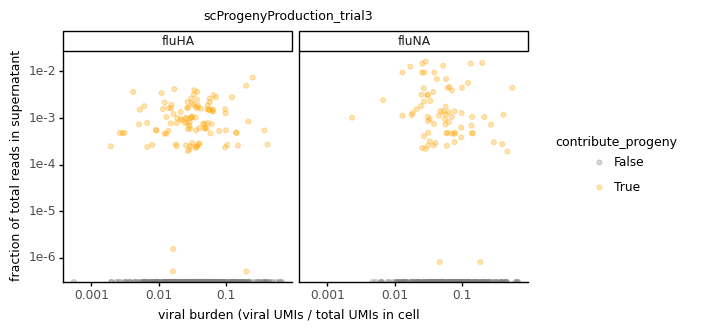

<ggplot: (8737370071050)>

In [88]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_sup',
                        color='contribute_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))

display(fig)

Look at the proportion of infected cells that contribute progeny vs those that don't and how that relates to having all viral genes. A priori, I would expect many more cells that contribute progeny to have all 8 genes than cells that don't.

In [89]:
pd.DataFrame(viral_bc_freqs.query('infected == True').groupby(['contribute_progeny'])['all_genes'].value_counts(normalize=True))

all_genes
contribute_progeny all_genes           
False              False       0.621122
                   True        0.378878
True               False       0.560768
                   True        0.439232

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


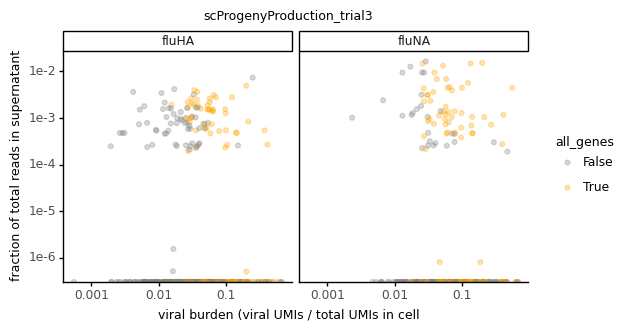

<ggplot: (8737369398414)>

In [90]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_sup',
                        color='all_genes')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)